### Variational Autoencoders for non-supervised intrusion detection

We train the variational autoencoders with 'normal' traffic <br>
We test it with 'attack' traffic and obtain result <br>
<br>
PCA Analysis of the results <br>
Visualization analysis on how the MAE splits the result <br>

\


In [1]:
# Pointer to check
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-10 08:06:16.939309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 08:06:16.939331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 129)
combine shape (78377, 129)
attack shape (55663, 129)


In [7]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

In [8]:
labels = combine_labels
ATTACK_LABEL = 1
NORMAL_LABEL = 0

norm_samples = df_scaled[labels == NORMAL_LABEL]  # normal data
attack_samples = df_scaled[labels == ATTACK_LABEL]  # attack data

norm_labels = labels[labels == NORMAL_LABEL]
attack_labels = labels[labels == ATTACK_LABEL]
print('normal size labels', norm_labels.shape)
print('attack size labels',attack_labels.shape)

normal size labels (22714,)
attack size labels (55663,)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.9 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
X_train.shape

(20442, 129)

In [11]:
X_test.shape

(4544, 129)

In [12]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [13]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 1024
latent_dim = 512

In [15]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         133120      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 512)          524800      ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 512)          524800      ['dense[0][0]']                  
                                                                                            

In [16]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 512)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 129)               132225    
                                                                 
Total params: 657,537
Trainable params: 657,537
Non-trainable params: 0
_________________________________________________________________


In [17]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [18]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [19]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 129)]             0         
                                                                 
 encoder (Functional)        (None, 512)               1182720   
                                                                 
 decoder (Functional)        (None, 129)               657537    
                                                                 
Total params: 1,840,257
Trainable params: 1,840,257
Non-trainable params: 0
_________________________________________________________________
Train on 20442 samples
Epoch 1/5000


2022-03-10 08:06:22.198609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 08:06:22.198877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 08:06:22.198928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 08:06:22.198975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 08:06:22.200469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

20442/20442 [==============================] - 2s 102us/sample - loss: 1626.6219
Epoch 2/5000
20442/20442 [==============================] - 2s 92us/sample - loss: 537.0955
Epoch 3/5000
20442/20442 [==============================] - 2s 92us/sample - loss: 381.5303
Epoch 4/5000
20442/20442 [==============================] - 2s 94us/sample - loss: 279.8377
Epoch 5/5000
20442/20442 [==============================] - 2s 92us/sample - loss: 233.6200
Epoch 6/5000
20442/20442 [==============================] - 2s 93us/sample - loss: 207.4047
Epoch 7/5000
20442/20442 [==============================] - 2s 93us/sample - loss: 188.0988
Epoch 8/5000
20442/20442 [==============================] - 2s 93us/sample - loss: 173.2634
Epoch 9/5000
20442/20442 [==============================] - 2s 93us/sample - loss: 160.8490
Epoch 10/5000
20442/20442 [==============================] - 2s 93us/sample - loss: 150.3069
Epoch 11/5000
20442/20442 [==============================] - 2s 94us/sample - loss: 141.22

20442/20442 [==============================] - 2s 111us/sample - loss: 31.9052
Epoch 90/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 31.5675
Epoch 91/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 31.4776
Epoch 92/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 30.8842
Epoch 93/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 30.5741
Epoch 94/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 30.7476
Epoch 95/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 30.0662
Epoch 96/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 30.2102
Epoch 97/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 30.3665
Epoch 98/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 29.4655
Epoch 99/5000
20442/20442 [==============================] - 2s 111us/sample - loss:

20442/20442 [==============================] - 2s 110us/sample - loss: 14.6533
Epoch 177/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 14.5329
Epoch 178/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 14.3485
Epoch 179/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 14.1735
Epoch 180/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 14.1176
Epoch 181/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 13.7831
Epoch 182/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 13.6539
Epoch 183/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 13.6450
Epoch 184/5000
20442/20442 [==============================] - 2s 112us/sample - loss: 13.4141
Epoch 185/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 13.4901
Epoch 186/5000
20442/20442 [==============================] - 2s 110us/samp

20442/20442 [==============================] - 2s 111us/sample - loss: 5.5954
Epoch 264/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 5.4892
Epoch 265/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 5.3980
Epoch 266/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 5.3680
Epoch 267/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 5.1616
Epoch 268/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 5.0987
Epoch 269/5000
20442/20442 [==============================] - 2s 111us/sample - loss: 5.2301
Epoch 270/5000
20442/20442 [==============================] - 2s 114us/sample - loss: 5.0262
Epoch 271/5000
20442/20442 [==============================] - 2s 112us/sample - loss: 5.0037
Epoch 272/5000
20442/20442 [==============================] - 2s 110us/sample - loss: 4.9177
Epoch 273/5000
20442/20442 [==============================] - 2s 111us/sample - loss:

20442/20442 [==============================] - 2s 112us/sample - loss: -0.3098
Epoch 352/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.3400
Epoch 353/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.3140
Epoch 354/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -0.3788
Epoch 355/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.5765
Epoch 356/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.6850
Epoch 357/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -0.7177
Epoch 358/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.7618
Epoch 359/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.5652
Epoch 360/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -0.8223
Epoch 361/5000
20442/20442 [==============================] - 2s 111us/samp

20442/20442 [==============================] - 2s 112us/sample - loss: -3.8318
Epoch 439/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -3.8909
Epoch 440/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -3.7903
Epoch 441/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -4.1043
Epoch 442/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -3.9559
Epoch 443/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -4.1295
Epoch 444/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -3.8466
Epoch 445/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -4.2056
Epoch 446/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -4.0214
Epoch 447/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -4.2511
Epoch 448/5000
20442/20442 [==============================] - 2s 111us/samp

20442/20442 [==============================] - 2s 112us/sample - loss: -6.5422
Epoch 526/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -6.4333
Epoch 527/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -6.5315
Epoch 528/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -6.4598
Epoch 529/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -6.4033
Epoch 530/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -6.6436
Epoch 531/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -6.5120
Epoch 532/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -6.6502
Epoch 533/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -6.8217
Epoch 534/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -6.6489
Epoch 535/5000
20442/20442 [==============================] - 2s 112us/samp

20442/20442 [==============================] - 2s 112us/sample - loss: -8.3541
Epoch 613/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.3223
Epoch 614/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -8.2619
Epoch 615/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.4328
Epoch 616/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.4912
Epoch 617/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.2273
Epoch 618/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.4187
Epoch 619/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.4050
Epoch 620/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.4743
Epoch 621/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -8.5185
Epoch 622/5000
20442/20442 [==============================] - 2s 112us/samp

20442/20442 [==============================] - 2s 112us/sample - loss: -9.6207
Epoch 700/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.6442
Epoch 701/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.6769
Epoch 702/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.6920
Epoch 703/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -9.6850
Epoch 704/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.6577
Epoch 705/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.7512
Epoch 706/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.7528
Epoch 707/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.7689
Epoch 708/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -9.8194
Epoch 709/5000
20442/20442 [==============================] - 2s 112us/samp

20442/20442 [==============================] - 2s 112us/sample - loss: -10.8317
Epoch 786/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.7199
Epoch 787/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.6854
Epoch 788/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -10.6782
Epoch 789/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.6676
Epoch 790/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.7655
Epoch 791/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.9005
Epoch 792/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -10.7794
Epoch 793/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -10.8617
Epoch 794/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -10.8259
Epoch 795/5000
20442/20442 [==============================] - 2s 

20442/20442 [==============================] - 2s 112us/sample - loss: -11.5777
Epoch 872/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -11.7291
Epoch 873/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -11.4282
Epoch 874/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -11.6630
Epoch 875/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -11.6233
Epoch 876/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -11.5237
Epoch 877/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -11.5597
Epoch 878/5000
20442/20442 [==============================] - 2s 114us/sample - loss: -11.6084
Epoch 879/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -11.7785
Epoch 880/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -11.5721
Epoch 881/5000
20442/20442 [==============================] - 2s 

20442/20442 [==============================] - 2s 113us/sample - loss: -12.2085
Epoch 958/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.4209
Epoch 959/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.2918
Epoch 960/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -12.4467
Epoch 961/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.3504
Epoch 962/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.3745
Epoch 963/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.2402
Epoch 964/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.3101
Epoch 965/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.2606
Epoch 966/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.3881
Epoch 967/5000
20442/20442 [==============================] - 2s 

Epoch 1043/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.0066
Epoch 1044/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -12.9684
Epoch 1045/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.9755
Epoch 1046/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -12.9642
Epoch 1047/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.0463
Epoch 1048/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -13.1185
Epoch 1049/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -12.9793
Epoch 1050/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.0125
Epoch 1051/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.0222
Epoch 1052/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.0991
Epoch 1053/5000
20442/20442 [===========

20442/20442 [==============================] - 2s 112us/sample - loss: -13.5233
Epoch 1129/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -13.5184
Epoch 1130/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.5086
Epoch 1131/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.5017
Epoch 1132/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.6119
Epoch 1133/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.5503
Epoch 1134/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -13.5653
Epoch 1135/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -13.5197
Epoch 1136/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.5719
Epoch 1137/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.6155
Epoch 1138/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -14.0113
Epoch 1214/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -13.9692
Epoch 1215/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -13.8965
Epoch 1216/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.9516
Epoch 1217/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.9066
Epoch 1218/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.0538
Epoch 1219/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -13.9380
Epoch 1220/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.0360
Epoch 1221/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.0615
Epoch 1222/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.0257
Epoch 1223/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 113us/sample - loss: -14.4050
Epoch 1299/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.4168
Epoch 1300/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4404
Epoch 1301/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.3355
Epoch 1302/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4358
Epoch 1303/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4435
Epoch 1304/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.4796
Epoch 1305/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4292
Epoch 1306/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4845
Epoch 1307/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.4340
Epoch 1308/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -14.6607
Epoch 1384/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8253
Epoch 1385/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.5790
Epoch 1386/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.6763
Epoch 1387/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8214
Epoch 1388/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8710
Epoch 1389/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.7221
Epoch 1390/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.6490
Epoch 1391/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7700
Epoch 1392/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7640
Epoch 1393/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -15.0552
Epoch 1469/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0560
Epoch 1470/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.9436
Epoch 1471/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.0739
Epoch 1472/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.0845
Epoch 1473/5000
20442/20442 [==============================] - 2s 114us/sample - loss: -14.9547
Epoch 1474/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0740
Epoch 1475/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.1168
Epoch 1476/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0802
Epoch 1477/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.9247
Epoch 1478/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -15.2553
Epoch 1554/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3182
Epoch 1555/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1856
Epoch 1556/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3627
Epoch 1557/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3029
Epoch 1558/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3019
Epoch 1559/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3668
Epoch 1560/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.4094
Epoch 1561/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3112
Epoch 1562/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.3600
Epoch 1563/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.4423
Epoch 1639/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.5067
Epoch 1640/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4422
Epoch 1641/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5052
Epoch 1642/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6236
Epoch 1643/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6320
Epoch 1644/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5317
Epoch 1645/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5621
Epoch 1646/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5696
Epoch 1647/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5634
Epoch 1648/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.5777
Epoch 1724/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7234
Epoch 1725/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8370
Epoch 1726/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.6305
Epoch 1727/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.7912
Epoch 1728/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.7501
Epoch 1729/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6590
Epoch 1730/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7981
Epoch 1731/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7321
Epoch 1732/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.7502
Epoch 1733/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.9202
Epoch 1809/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.9017
Epoch 1810/5000
20442/20442 [==============================] - 2s 114us/sample - loss: -15.8749
Epoch 1811/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.9324
Epoch 1812/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -16.0566
Epoch 1813/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8179
Epoch 1814/5000
20442/20442 [==============================] - 2s 114us/sample - loss: -15.8981
Epoch 1815/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9913
Epoch 1816/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9183
Epoch 1817/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9014
Epoch 1818/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -16.1445
Epoch 1894/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0474
Epoch 1895/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9922
Epoch 1896/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -16.0769
Epoch 1897/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1440
Epoch 1898/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0217
Epoch 1899/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1061
Epoch 1900/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0990
Epoch 1901/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9412
Epoch 1902/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0414
Epoch 1903/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -16.2233
Epoch 1979/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1353
Epoch 1980/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2072
Epoch 1981/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2042
Epoch 1982/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -16.1536
Epoch 1983/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -16.1646
Epoch 1984/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1734
Epoch 1985/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2490
Epoch 1986/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1459
Epoch 1987/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.3194
Epoch 1988/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -16.0800
Epoch 2064/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1869
Epoch 2065/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0089
Epoch 2066/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.3012
Epoch 2067/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -16.0791
Epoch 2068/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.3121
Epoch 2069/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2478
Epoch 2070/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.1731
Epoch 2071/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2674
Epoch 2072/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.3163
Epoch 2073/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -16.1348
Epoch 2149/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2321
Epoch 2150/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9081
Epoch 2151/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9986
Epoch 2152/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2119
Epoch 2153/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.2436
Epoch 2154/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.5157
Epoch 2155/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -16.1550
Epoch 2156/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -16.1672
Epoch 2157/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -16.0957
Epoch 2158/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -16.1584
Epoch 2234/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8733
Epoch 2235/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8522
Epoch 2236/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.7392
Epoch 2237/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8450
Epoch 2238/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8341
Epoch 2239/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9667
Epoch 2240/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -16.0204
Epoch 2241/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7412
Epoch 2242/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7706
Epoch 2243/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.5171
Epoch 2319/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4768
Epoch 2320/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3953
Epoch 2321/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4786
Epoch 2322/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5861
Epoch 2323/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5532
Epoch 2324/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.4526
Epoch 2325/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3695
Epoch 2326/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.3469
Epoch 2327/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3824
Epoch 2328/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.2224
Epoch 2404/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1297
Epoch 2405/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0842
Epoch 2406/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.8931
Epoch 2407/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2030
Epoch 2408/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9296
Epoch 2409/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0812
Epoch 2410/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2801
Epoch 2411/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0935
Epoch 2412/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7845
Epoch 2413/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.8406
Epoch 2489/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.6216
Epoch 2490/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7138
Epoch 2491/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6912
Epoch 2492/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7144
Epoch 2493/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9744
Epoch 2494/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.9025
Epoch 2495/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8460
Epoch 2496/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6106
Epoch 2497/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.7102
Epoch 2498/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.9027
Epoch 2574/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.7923
Epoch 2575/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7334
Epoch 2576/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -14.2014
Epoch 2577/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.7546
Epoch 2578/5000
20442/20442 [==============================] - 3s 123us/sample - loss: -14.5696
Epoch 2579/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.4684
Epoch 2580/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7675
Epoch 2581/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5314
Epoch 2582/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6645
Epoch 2583/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -14.8587
Epoch 2659/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8903
Epoch 2660/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8747
Epoch 2661/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5211
Epoch 2662/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5531
Epoch 2663/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.9132
Epoch 2664/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7028
Epoch 2665/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9083
Epoch 2666/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.0596
Epoch 2667/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6544
Epoch 2668/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.6586
Epoch 2744/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.7555
Epoch 2745/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5864
Epoch 2746/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6789
Epoch 2747/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.3875
Epoch 2748/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.2984
Epoch 2749/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.5083
Epoch 2750/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7139
Epoch 2751/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.4783
Epoch 2752/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.4738
Epoch 2753/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -14.7195
Epoch 2829/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -14.8035
Epoch 2830/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.8321
Epoch 2831/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8717
Epoch 2832/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.0414
Epoch 2833/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.8989
Epoch 2834/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.9951
Epoch 2835/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.6036
Epoch 2836/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.8273
Epoch 2837/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.7242
Epoch 2838/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.0710
Epoch 2914/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.9286
Epoch 2915/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9247
Epoch 2916/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.1599
Epoch 2917/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6827
Epoch 2918/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9420
Epoch 2919/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9494
Epoch 2920/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0316
Epoch 2921/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0265
Epoch 2922/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9880
Epoch 2923/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.8837
Epoch 2999/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1244
Epoch 3000/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.7531
Epoch 3001/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9446
Epoch 3002/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0633
Epoch 3003/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7392
Epoch 3004/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.7904
Epoch 3005/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0411
Epoch 3006/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0626
Epoch 3007/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0979
Epoch 3008/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.2432
Epoch 3084/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0618
Epoch 3085/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3446
Epoch 3086/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9027
Epoch 3087/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.4735
Epoch 3088/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.1469
Epoch 3089/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5980
Epoch 3090/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1343
Epoch 3091/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0687
Epoch 3092/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1518
Epoch 3093/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.7928
Epoch 3169/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9620
Epoch 3170/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1099
Epoch 3171/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0570
Epoch 3172/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9535
Epoch 3173/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8948
Epoch 3174/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.9394
Epoch 3175/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0104
Epoch 3176/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0384
Epoch 3177/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6328
Epoch 3178/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -14.6408
Epoch 3254/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.5963
Epoch 3255/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.1481
Epoch 3256/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9229
Epoch 3257/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.1186
Epoch 3258/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9723
Epoch 3259/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1020
Epoch 3260/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0149
Epoch 3261/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -14.8909
Epoch 3262/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1554
Epoch 3263/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.7101
Epoch 3339/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0419
Epoch 3340/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2190
Epoch 3341/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -14.7746
Epoch 3342/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0738
Epoch 3343/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.1802
Epoch 3344/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.1844
Epoch 3345/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0280
Epoch 3346/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9753
Epoch 3347/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7887
Epoch 3348/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.2362
Epoch 3424/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8927
Epoch 3425/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1310
Epoch 3426/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9047
Epoch 3427/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.3310
Epoch 3428/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8309
Epoch 3429/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2904
Epoch 3430/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3733
Epoch 3431/5000
20442/20442 [==============================] - ETA: 0s - loss: -14.972 - 2s 112us/sample - loss: -14.9878
Epoch 3432/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.0094
Epoch 3433/5000
20442/20442 [=

20442/20442 [==============================] - 2s 111us/sample - loss: -15.0639
Epoch 3509/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3080
Epoch 3510/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.6174
Epoch 3511/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.4311
Epoch 3512/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4277
Epoch 3513/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2621
Epoch 3514/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.0315
Epoch 3515/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1190
Epoch 3516/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2298
Epoch 3517/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.2362
Epoch 3518/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.0238
Epoch 3594/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0454
Epoch 3595/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4774
Epoch 3596/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3557
Epoch 3597/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0571
Epoch 3598/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4979
Epoch 3599/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3158
Epoch 3600/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1762
Epoch 3601/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.2301
Epoch 3602/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4428
Epoch 3603/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.2702
Epoch 3679/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6053
Epoch 3680/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6439
Epoch 3681/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.1211
Epoch 3682/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.6401
Epoch 3683/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5795
Epoch 3684/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2939
Epoch 3685/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.3785
Epoch 3686/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5454
Epoch 3687/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4570
Epoch 3688/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.1796
Epoch 3764/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7379
Epoch 3765/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8039
Epoch 3766/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8331
Epoch 3767/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1582
Epoch 3768/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4327
Epoch 3769/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7452
Epoch 3770/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4775
Epoch 3771/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6686
Epoch 3772/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7610
Epoch 3773/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.5203
Epoch 3849/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3253
Epoch 3850/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6947
Epoch 3851/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8105
Epoch 3852/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2547
Epoch 3853/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8963
Epoch 3854/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.6398
Epoch 3855/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.0441
Epoch 3856/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2377
Epoch 3857/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7223
Epoch 3858/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.6749
Epoch 3934/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5931
Epoch 3935/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5049
Epoch 3936/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.9465
Epoch 3937/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.4422
Epoch 3938/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7563
Epoch 3939/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7365
Epoch 3940/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7831
Epoch 3941/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.6200
Epoch 3942/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3426
Epoch 3943/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.6315
Epoch 4019/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3757
Epoch 4020/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0822
Epoch 4021/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4766
Epoch 4022/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6289
Epoch 4023/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.6468
Epoch 4024/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1415
Epoch 4025/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6821
Epoch 4026/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.5793
Epoch 4027/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4143
Epoch 4028/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 112us/sample - loss: -15.4160
Epoch 4104/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3955
Epoch 4105/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0336
Epoch 4106/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4944
Epoch 4107/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.2626
Epoch 4108/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5458
Epoch 4109/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.7595
Epoch 4110/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0495
Epoch 4111/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3386
Epoch 4112/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4324
Epoch 4113/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.3759
Epoch 4189/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4308
Epoch 4190/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4045
Epoch 4191/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4474
Epoch 4192/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4291
Epoch 4193/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5767
Epoch 4194/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5573
Epoch 4195/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4523
Epoch 4196/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4393
Epoch 4197/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9734
Epoch 4198/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.3894
Epoch 4274/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5524
Epoch 4275/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7496
Epoch 4276/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3451
Epoch 4277/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5140
Epoch 4278/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4582
Epoch 4279/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4589
Epoch 4280/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4253
Epoch 4281/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4767
Epoch 4282/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5575
Epoch 4283/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.7592
Epoch 4359/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.4840
Epoch 4360/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2627
Epoch 4361/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.5105
Epoch 4362/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1902
Epoch 4363/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5190
Epoch 4364/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2527
Epoch 4365/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.1916
Epoch 4366/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.2973
Epoch 4367/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.4794
Epoch 4368/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.5954
Epoch 4444/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1730
Epoch 4445/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5811
Epoch 4446/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4161
Epoch 4447/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9677
Epoch 4448/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3081
Epoch 4449/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5039
Epoch 4450/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.1428
Epoch 4451/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.5077
Epoch 4452/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3598
Epoch 4453/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.6676
Epoch 4529/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.1575
Epoch 4530/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7103
Epoch 4531/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4471
Epoch 4532/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2940
Epoch 4533/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5514
Epoch 4534/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4714
Epoch 4535/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6681
Epoch 4536/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.5270
Epoch 4537/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6104
Epoch 4538/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.1627
Epoch 4614/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3250
Epoch 4615/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.0380
Epoch 4616/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4710
Epoch 4617/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4340
Epoch 4618/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.6397
Epoch 4619/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6766
Epoch 4620/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2452
Epoch 4621/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8067
Epoch 4622/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.8993
Epoch 4623/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.0879
Epoch 4699/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4335
Epoch 4700/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.2777
Epoch 4701/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5450
Epoch 4702/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.0699
Epoch 4703/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2612
Epoch 4704/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5888
Epoch 4705/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3086
Epoch 4706/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.4068
Epoch 4707/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6514
Epoch 4708/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -14.6835
Epoch 4784/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.2100
Epoch 4785/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.5143
Epoch 4786/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1022
Epoch 4787/5000
20442/20442 [==============================] - 2s 112us/sample - loss: -15.5069
Epoch 4788/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.3614
Epoch 4789/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -14.9043
Epoch 4790/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3837
Epoch 4791/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.5537
Epoch 4792/5000
20442/20442 [==============================] - 2s 113us/sample - loss: -15.4322
Epoch 4793/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.8383
Epoch 4869/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3467
Epoch 4870/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5136
Epoch 4871/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.1534
Epoch 4872/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7050
Epoch 4873/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.1857
Epoch 4874/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.6023
Epoch 4875/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3400
Epoch 4876/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2470
Epoch 4877/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7183
Epoch 4878/5000
20442/20442 [===========================

20442/20442 [==============================] - 2s 111us/sample - loss: -15.4507
Epoch 4954/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.2730
Epoch 4955/5000
20442/20442 [==============================] - 2s 110us/sample - loss: -15.3751
Epoch 4956/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.8319
Epoch 4957/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6952
Epoch 4958/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6325
Epoch 4959/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.3365
Epoch 4960/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.6494
Epoch 4961/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.5568
Epoch 4962/5000
20442/20442 [==============================] - 2s 111us/sample - loss: -15.7847
Epoch 4963/5000
20442/20442 [===========================

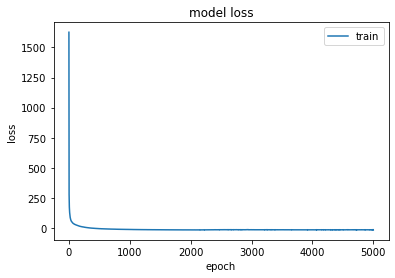

In [20]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [21]:
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.95)
print(error_thresh)

Avg error 0.006427707569032037
median error 0.005595351747088187
99Q: 0.019978166346237877
setting threshold on 0.019978166346237877 
0.012457463491617688


In [23]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 4544
1720
total y_test 4544
2272


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      2272
         1.0       0.91      0.69      0.78      2272

    accuracy                           0.81      4544
   macro avg       0.83      0.81      0.81      4544
weighted avg       0.83      0.81      0.81      4544



In [25]:
X_pred.shape

(4544, 129)

In [26]:
X_encoded = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_transform = pca.fit_transform(X_encoded)

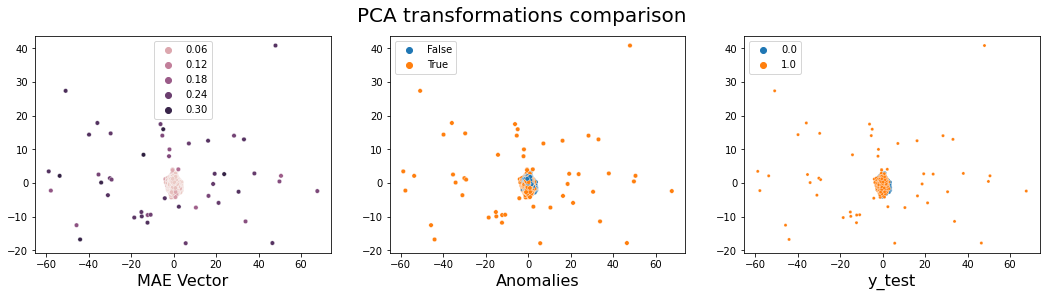

In [28]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.show()

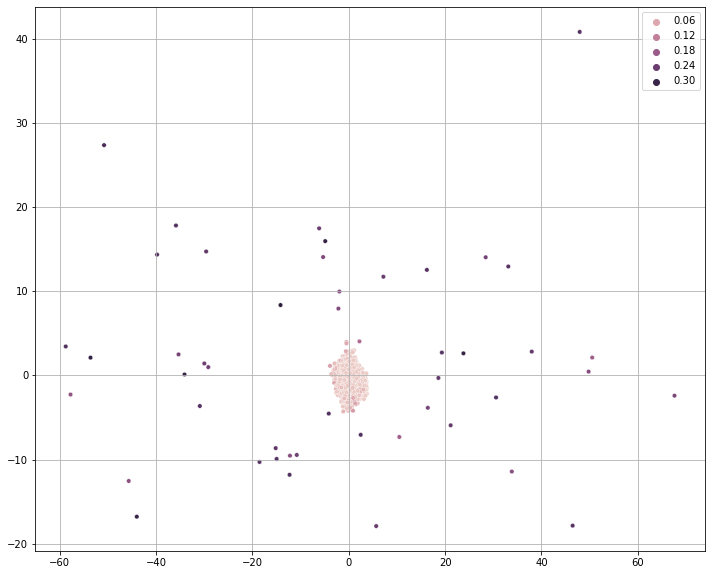

In [29]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

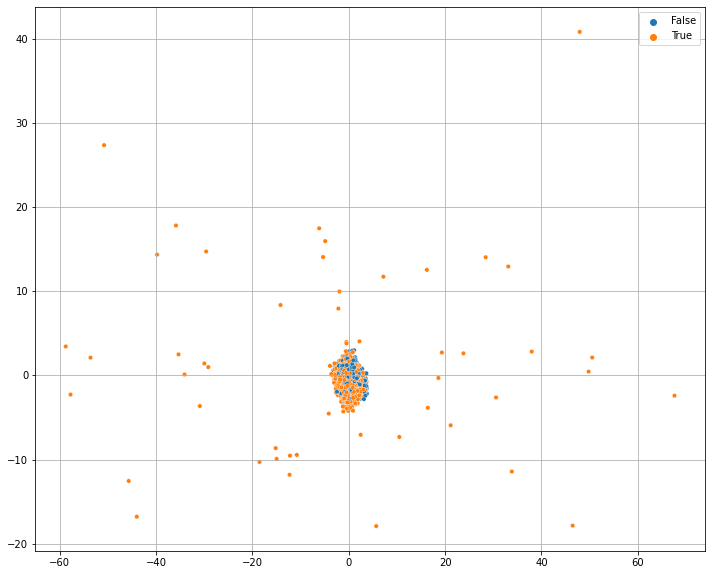

In [30]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

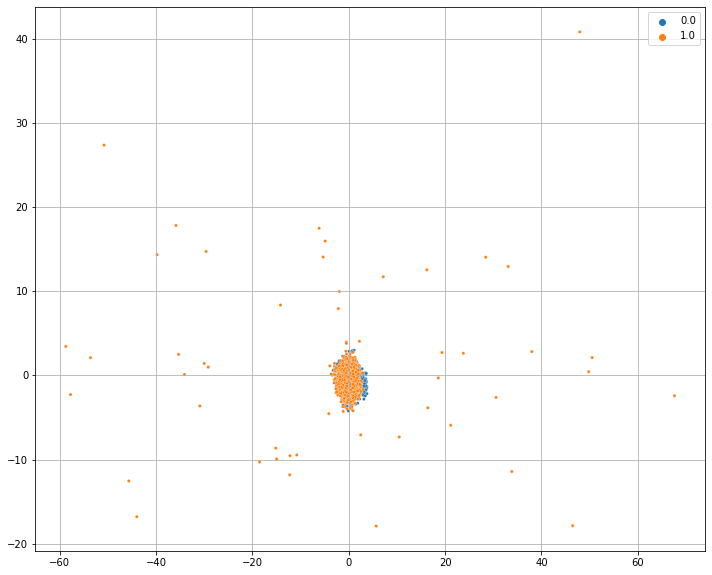

In [31]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [32]:
X_pred.shape

(4544, 129)

0.012457463491617688


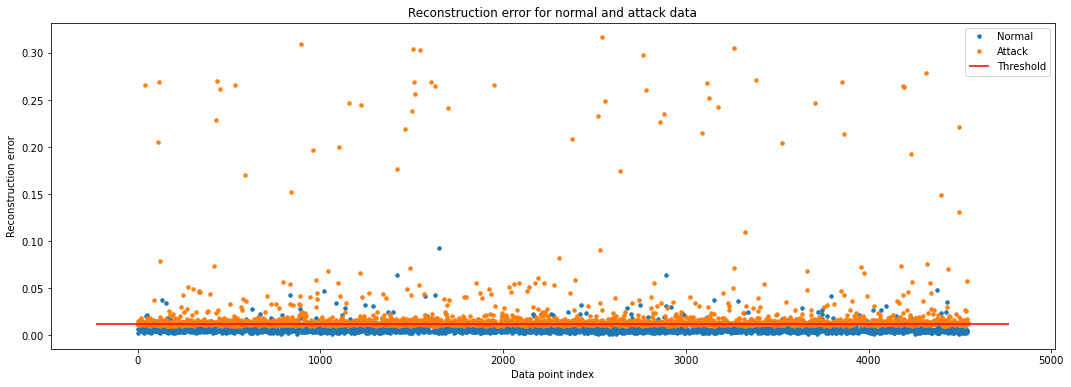

In [33]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()